In [9]:
!pip install connectivipy

  Created wheel for connectivipy: filename=connectivipy-0.36-cp36-none-any.whl size=23689 sha256=122775ced573c7cc25d41c786dd431aeb8a6610f24b827680dbdbd7fed17f201
  Stored in directory: /home/banusha/.cache/pip/wheels/83/fd/d8/e1700c85ae7e9fecd3c572e9d4cb9f62b0568f7e962dd19402
Successfully built connectivipy


In [ ]:
!pip install pyEDFlib

In [80]:
!pip install networkx

     |████████████████████████████████| 1.6MB 839kB/s eta 0:00:01


In [1]:
import numpy as np
import pyedflib
import pandas as pd
import connectivipy as cp

In [2]:
file_name= 'S038R01.edf'

In [3]:
def read_data_file(file):
    f = pyedflib.EdfReader(file)
    n = f.signals_in_file
    signal_labels = f.getSignalLabels()
    sigbufs = np.zeros((n, f.getNSamples()[0]))
    for i in np.arange(n):
        sigbufs[i, :] = f.readSignal(i)
    #data=pd.DataFrame(sigbufs).T
    #data.columns=signal_labels
    return signal_labels,sigbufs

In [4]:
labels, data = read_data_file(file_name)

(mandatory) Estimate functional brain connectivity among 64 channels using one of the
MVAR estimators: Partial Directed Coherence (PDC), Direct Transfer Function (DTF). Select
one relevant frequency value. Apply a threshold so that the resulting binary connectivity
matrices have network density equal to 20%. Create a graphical representation of the binary
adjacency matrix.

https://connectivipy.readthedocs.io/en/latest/tutorial.html

In [5]:
len(labels)

64

In [6]:
data.shape

(64, 9760)

In [7]:
dt = cp.Data(data, fs=1., chan_names=labels, data_info='sml')

/home/banusha/nnenv/lib/python3.6/site-packages/connectivipy/data.py:340: Warning: Number of channels > 10.
                          Consider picking only some channels.
  Consider picking only some channels.""", Warning)


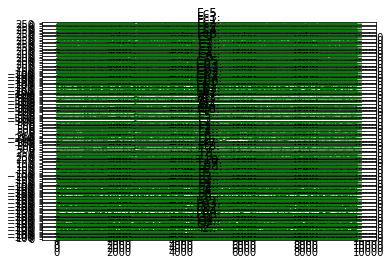

In [8]:
dt.plot_data(trial=0)

In [21]:
dt.fit_mvar(25, 'yw')

In [22]:
ar, vr = dt.mvar_coefficients

In [23]:
ar.shape

(25, 64, 64)

In [24]:
vr.shape

(64, 64)

In [25]:
gdtf_values = dt.conn('gdtf')

In [26]:
gdtf_values.shape

(100, 64, 64)

In [27]:
gdtf_significance = dt.significance(Nrep=200, alpha=0.05)

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . |


In [28]:
gdtf_significance.shape

(64, 64)

In [29]:
gdtf_significance

array([[0.94288518, 0.12368619, 0.12145575, ..., 0.11742434, 0.13510081,
        0.15037422],
       [0.12952213, 0.92950914, 0.14017814, ..., 0.11670535, 0.12584173,
        0.13284562],
       [0.12775333, 0.1185669 , 0.92602826, ..., 0.11919748, 0.12603557,
        0.11797514],
       ...,
       [0.14053551, 0.13266553, 0.12540869, ..., 0.94952003, 0.12682928,
        0.13229343],
       [0.14021892, 0.12321402, 0.11824408, ..., 0.1196592 , 0.94146851,
        0.1222906 ],
       [0.12970374, 0.14251274, 0.13177028, ..., 0.13051901, 0.14475856,
        0.96551017]])

In [51]:
np.sum(gdtf_significance>0.135)-64

886

In [54]:
adj_matr = 1*(gdtf_significance>0.135)

In [55]:
(np.sum(adj_matr)-64)/(64**2) # density of network

0.21630859375

In [62]:
idx_i, inx_j = np.where(adj_matr==1)

In [64]:
idx_i, inx_j = list(idx_i), list(inx_j )

In [76]:
def check_symmetric(a, tol=1e-8):
    return np.all(np.abs(a-a.T) < tol)

In [77]:
check_symmetric(adj_matr)

False

In [73]:
Edges = [(idx_i[i],inx_j[i]) for i in range(len(idx_i)) if (idx_i[i]!=inx_j[i])]

In [82]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx

In [94]:
our_graph=nx.DiGraph()

In [95]:
our_graph.add_nodes_from(range(0,64))

In [96]:
our_graph.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63))

In [97]:
our_graph.add_edges_from(Edges)

In [98]:
our_graph.edges

OutEdgeView([(0, 17), (0, 21), (0, 25), (0, 27), (0, 28), (0, 29), (0, 30), (0, 36), (0, 37), (0, 38), (0, 49), (0, 51), (0, 55), (0, 58), (0, 62), (0, 63), (1, 2), (1, 5), (1, 26), (1, 28), (1, 34), (1, 36), (1, 55), (1, 58), (2, 5), (2, 6), (2, 11), (2, 15), (2, 18), (2, 20), (2, 22), (2, 32), (2, 33), (2, 53), (2, 59), (3, 1), (3, 11), (3, 43), (3, 51), (3, 58), (4, 11), (4, 14), (4, 26), (4, 35), (4, 48), (4, 57), (5, 9), (5, 10), (5, 22), (5, 23), (5, 25), (5, 32), (5, 40), (5, 50), (5, 52), (5, 53), (5, 55), (6, 1), (6, 5), (6, 9), (6, 29), (6, 31), (6, 35), (6, 51), (6, 60), (6, 62), (6, 63), (7, 2), (7, 17), (7, 20), (7, 22), (7, 24), (7, 27), (7, 43), (7, 55), (7, 56), (7, 57), (7, 58), (7, 60), (8, 29), (8, 30), (8, 34), (8, 49), (8, 51), (8, 53), (8, 55), (8, 57), (8, 59), (9, 6), (9, 11), (9, 13), (9, 40), (9, 48), (9, 50), (9, 52), (9, 55), (9, 59), (9, 62), (10, 38), (10, 44), (10, 54), (11, 4), (11, 5), (11, 7), (11, 8), (11, 12), (11, 17), (11, 18), (11, 21), (11, 26), 

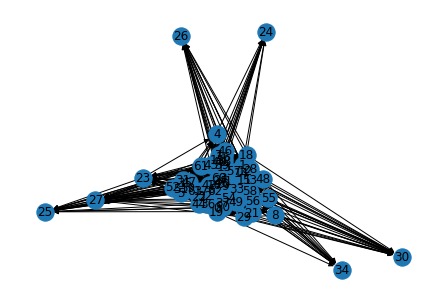

In [100]:
nx.draw(our_graph,with_labels=True)
plt.draw()
plt.show()